# Using solely a pretrained network

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

!pip install opencv-python

import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 45.9MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
def detect_objects_in_video(input_path, output_path):
    # Open video file
    video = cv2.VideoCapture(input_path)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    # Define codec and create VideoWriter object
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break

        # Convert frame to tensor
        tensor = F.to_tensor(frame).unsqueeze(0).cuda()

        # Get predictions
        with torch.no_grad():
            prediction = model(tensor)

        # Draw boxes
        for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
            if score > 0.5:  # you can adjust the threshold here
                box = box.int().cpu().numpy()
                class_name = COCO_CLASSES[label]
                frame = cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                frame = cv2.putText(frame, class_name, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


        out.write(frame)

    video.release()
    out.release()

In [ ]:
from google.colab import files
uploaded = files.upload()
video_name = list(uploaded.keys())[0]

Saving Щас щас щас Путин ОРИГИНАЛ [1080p 60 FPS].mp4 to Щас щас щас Путин ОРИГИНАЛ [1080p 60 FPS].mp4


In [ ]:
output_video_name = "output_" + video_name
detect_objects_in_video(video_name, output_video_name)

In [ ]:
files.download(output_video_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Writing a Faster R-CNN model from scratch


In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

!pip install opencv-python

import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.datasets import VOCDetection

In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

--2023-10-28 19:39:59--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  24.9MB/s    in 75s     

2023-10-28 19:41:14 (25.6 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [3]:
!ls VOCdevkit/VOC2012/Annotations


def parse_annotations(anno_path):
    img_annotations = {}  # Renamed from annotations to avoid confusion

    for file in os.listdir(anno_path):
        if file.endswith('.xml'):
            file_path = os.path.join(anno_path, file)
            tree = ET.parse(file_path)
            root = tree.getroot()

            boxes = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                box = obj.find('bndbox')
                xmin = int(round(float(box.find('xmin').text)))
                ymin = int(round(float(box.find('ymin').text)))
                xmax = int(round(float(box.find('xmax').text)))
                ymax = int(round(float(box.find('ymax').text)))

                boxes.append((label, xmin, ymin, xmax, ymax))

            if boxes:
                img_annotations[file[:-4]] = boxes  # Use img_annotations here

    return img_annotations  # Return the dictionary

anno_path = 'VOCdevkit/VOC2012/Annotations'
annotations = parse_annotations(anno_path)

2007_000027.xml  2008_005376.xml  2009_003407.xml  2010_004942.xml  2011_004709.xml
2007_000032.xml  2008_005378.xml  2009_003409.xml  2010_004943.xml  2011_004711.xml
2007_000033.xml  2008_005379.xml  2009_003411.xml  2010_004944.xml  2011_004717.xml
2007_000039.xml  2008_005380.xml  2009_003415.xml  2010_004945.xml  2011_004718.xml
2007_000042.xml  2008_005382.xml  2009_003416.xml  2010_004946.xml  2011_004720.xml
2007_000061.xml  2008_005386.xml  2009_003417.xml  2010_004948.xml  2011_004724.xml
2007_000063.xml  2008_005389.xml  2009_003419.xml  2010_004950.xml  2011_004725.xml
2007_000068.xml  2008_005393.xml  2009_003422.xml  2010_004951.xml  2011_004726.xml
2007_000121.xml  2008_005395.xml  2009_003425.xml  2010_004952.xml  2011_004727.xml
2007_000123.xml  2008_005396.xml  2009_003430.xml  2010_004953.xml  2011_004728.xml
2007_000129.xml  2008_005398.xml  2009_003431.xml  2010_004954.xml  2011_004730.xml
2007_000170.xml  2008_005399.xml  2009_003433.xml  2010_004957.xml  2011_004

In [4]:
annotations.get('2012_000051')

[('person', 9, 206, 33, 261), ('person', 103, 201, 123, 245)]

In [4]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
from torchvision.transforms import transforms
import math
from torchvision.models.detection.rpn import AnchorGenerator

from sklearn.model_selection import train_test_split
from numpy.core.fromnumeric import resize
import cv2
from torchvision.transforms import ToTensor
from torchvision.ops import RoIAlign
import torch.nn as nn


img_annotations = parse_annotations('VOCdevkit/VOC2012/Annotations')
img_names = list(img_annotations.keys())
split = int(0.8 * len(img_names))
X_train = img_names[:split]
X_test = img_names[split:]

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)


def get_label_map(annotations):
    unique_labels = set(label for anno in annotations.values() for label, _, _, _, _ in anno)
    return {label: idx for idx, label in enumerate(unique_labels, start=1)}

label_map = get_label_map(img_annotations)

# Annotation Parsing
def parse_annotations(anno_path):
    img_annotations = {}
    for file in os.listdir(anno_path):
        if file.endswith('.xml'):
            file_path = os.path.join(anno_path, file)
            tree = ET.parse(file_path)
            root = tree.getroot()

            boxes = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                box = obj.find('bndbox')
                xmin = int(round(float(box.find('xmin').text)))
                ymin = int(round(float(box.find('ymin').text)))
                xmax = int(round(float(box.find('xmax').text)))
                ymax = int(round(float(box.find('ymax').text)))
                boxes.append((label, xmin, ymin, xmax, ymax))

            if boxes:
                img_annotations[file[:-4]] = boxes
    return img_annotations



# Dataset class
class VOCDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        self.img_dir = img_dir
        self.img_names = list(annotations.keys())
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        boxes = []
        labels = []
        for label, xmin, ymin, xmax, ymax in self.annotations[img_name]:
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_map[label])
        boxes = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        # Construct target dictionary for each image
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        return image, target

# Transformations and Data Loaders
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600, 800)),
    transforms.ToTensor()
])

img_dir = 'VOCdevkit/VOC2012/JPEGImages'
train_dataset = VOCDataset(img_dir, {name: annotations[name] for name in X_train}, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Further layers
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # You can add more layers as needed

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))

        # If you add more layers, include them in the forward pass

        return x

from torchvision.models.resnet import resnet50, Bottleneck

def get_resnet50_backbone():
    # Load the pre-trained weights of the full ResNet50 model
    model = resnet50(pretrained=True)

    # Remove avgpool and fc layers to get the feature maps
    modules = list(model.children())[:-2]

    # Construct the new backbone
    backbone = nn.Sequential(*modules)

    # Set the number of out channels
    backbone.out_channels = 2048

    return backbone

backbone = get_resnet50_backbone()

# Removing the CustomAnchorGenerator class as it's not needed

# Create the Faster R-CNN model

#backbone = resnet50(pretrained=True)
#backbone = CustomBackbone()
#backbone.out_channels = 512 # 2048
#backbone.out_channels = 2048


# Using the built-in AnchorGenerator for RPN
rpn_anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),) * 5)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=21,
                   rpn_anchor_generator=rpn_anchor_generator,  # Using the built-in AnchorGenerator here
                   box_roi_pool=roi_pooler)

train_dataset = VOCDataset(img_dir, {name: img_annotations[name] for name in X_train}, transform=transform)
test_dataset = VOCDataset(img_dir, {name: img_annotations[name] for name in X_test}, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 44.8MB/s]


In [6]:
import torch
from google.colab import drive
drive.mount('/content/drive')


class Trainer:
    def __init__(self, model, train_loader, test_loader, lr=0.005, momentum=0.9, weight_decay=0.0005, num_epochs=1):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.num_epochs = num_epochs

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            for batch_idx, (batched_images, batched_targets) in enumerate(self.train_loader):
                images = [img.to(self.device) for img in batched_images]
                print(batched_targets)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in batched_targets]

                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()

                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()

                if batch_idx % 10 == 0: # Print every 10 batches. You can change this as per your requirement.
                    print(f"Epoch [{epoch+1}/{self.num_epochs}], Batch [{batch_idx+1}/{len(self.train_loader)}], Loss: {losses.item()}")

            avg_loss = total_loss / len(self.train_loader)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Average Loss: {avg_loss}")

        print("Training Complete!")

    def predict(self):
        self.model.eval()
        with torch.no_grad():
            for images, _ in self.test_loader:
                images = list(img.to(self.device) for img in images)
                prediction = self.model(images)
                print(prediction)
                break

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved at {path}")

# Usage
trainer = Trainer(model, train_loader, test_loader, num_epochs=1)
#trainer.train()
trainer.predict()
SAVE_PATH = '/content/drive/MyDrive/model_weights_with_resnet50.pth'
#trainer.save_model(SAVE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[{'boxes': tensor([[ 57.8622,  24.6681, 357.8513, 403.8081],
        [ 79.2657,  26.1723, 244.1793, 361.0571],
        [ 12.5463,  30.5284, 190.4866, 361.3374],
        [158.1492,   8.9587, 473.8982, 385.3672],
        [ 23.3638,  32.7470, 217.5878, 218.2026],
        [289.5469,  15.5129, 577.6490, 430.4047],
        [131.8027,  28.5656, 314.3633, 281.8220],
        [ 60.4838, 115.9568, 497.4759, 450.0789]], device='cuda:0'), 'labels': tensor([4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0'), 'scores': tensor([0.6482, 0.2665, 0.2140, 0.1126, 0.0779, 0.0705, 0.0572, 0.0546],
       device='cuda:0')}]


# Predicting

### Photo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[{'boxes': tensor([[ 12.3113,  12.7681, 360.7893, 441.6030],
        [  7.1325,  11.8860, 415.9377, 362.8772],
        [ 82.9495,  29.3689, 282.2807, 391.5109]], device='cuda:0'), 'labels': tensor([4, 9, 4], device='cuda:0'), 'scores': tensor([0.1487, 0.0916, 0.0755], device='cuda:0')}]


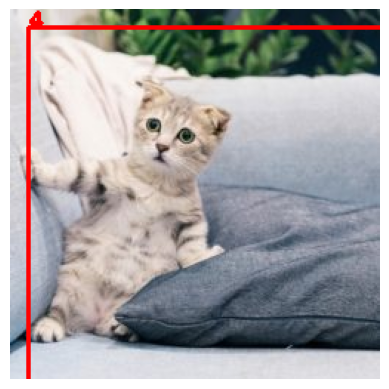

[{'boxes': tensor([[  0.0000,  20.5380, 466.0569, 380.7856],
        [ 61.2507,  32.2883, 352.3830, 292.4142],
        [ 32.7834,  37.2868, 416.4968, 332.7254],
        [  0.0000,  26.9537, 269.1299, 468.3391],
        [213.3070,  30.2327, 579.1860, 370.1924],
        [209.5627,   9.0656, 576.2870, 390.8688],
        [  0.0000, 224.0795, 248.5319, 543.3739],
        [  0.0000,  26.5626, 317.7890, 447.7649],
        [  0.0000,  36.4233, 258.9632, 457.3045]], device='cuda:0'), 'labels': tensor([ 9,  9, 12,  9, 12,  9,  9,  4, 12], device='cuda:0'), 'scores': tensor([0.3988, 0.2128, 0.1967, 0.1339, 0.0921, 0.0911, 0.0836, 0.0576, 0.0565],
       device='cuda:0')}]


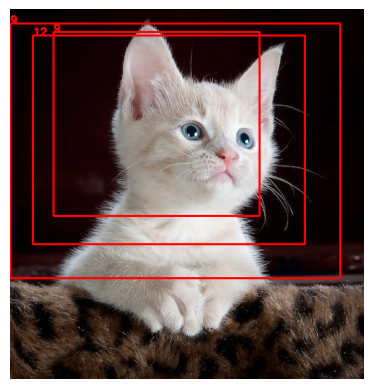

[{'boxes': tensor([[ 34.1968,  23.3878, 414.7936, 341.3788],
        [ 98.5275,  43.8650, 311.0008, 320.2055],
        [ 62.9681,  42.6039, 448.9599, 358.3421],
        [ 81.6349,  33.9545, 254.0377, 343.4379],
        [ 28.7598,  72.0966, 363.3292, 229.6894],
        [100.0080,  16.8872, 304.4884, 414.7653],
        [ 44.8213,  75.7230, 358.8345, 227.7104],
        [111.1564,  34.7444, 190.5548, 259.4627],
        [ 80.3336,  23.1538, 451.4742, 372.3665],
        [ 67.2767,  22.2833, 424.5254, 383.1013],
        [ 49.8915,  20.5590, 339.2856, 454.1740]], device='cuda:0'), 'labels': tensor([ 9, 12, 12,  4,  9,  9, 12,  4, 14,  7,  4], device='cuda:0'), 'scores': tensor([0.2470, 0.2018, 0.1448, 0.1122, 0.1096, 0.0921, 0.0767, 0.0637, 0.0625,
        0.0584, 0.0539], device='cuda:0')}]


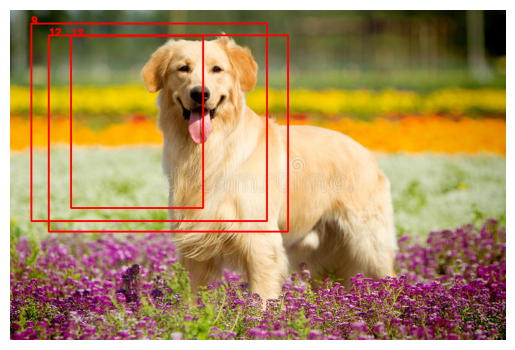

[{'boxes': tensor([[140.4861,  38.4076, 294.4049, 336.3445],
        [124.2802,  25.2683, 442.6729, 378.8142],
        [107.7406,  48.9739, 562.2051, 316.1071],
        [ 99.9637,  41.1872, 566.1859, 326.4769],
        [172.7768,  54.3521, 397.5360, 286.4527],
        [ 22.6259,  10.2005, 378.8005, 439.6797],
        [184.1949,  56.2712, 257.5343, 249.8853],
        [ 74.3488,  30.3455, 304.2017, 465.7343],
        [ 92.9868,  38.3157, 372.7984, 427.4805],
        [252.0832,  42.1632, 496.6384, 346.1922],
        [ 89.1080,  35.2444, 365.1514, 471.3948],
        [118.2840,  42.3896, 366.8705, 306.3615],
        [ 95.8483,  47.8099, 587.4327, 369.2625]], device='cuda:0'), 'labels': tensor([ 4,  4, 12,  9, 12,  9,  4,  4, 12,  4,  7,  9,  7], device='cuda:0'), 'scores': tensor([0.2652, 0.2292, 0.1749, 0.1203, 0.0912, 0.0788, 0.0686, 0.0604, 0.0597,
        0.0583, 0.0551, 0.0510, 0.0502], device='cuda:0')}]


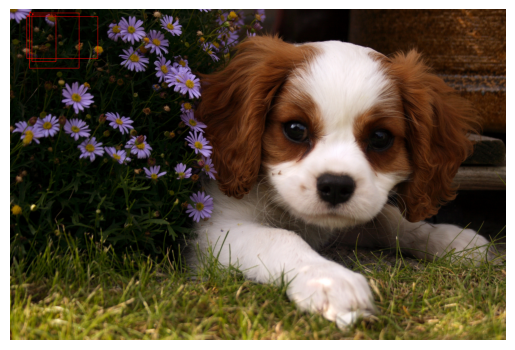

In [11]:
import matplotlib.pyplot as plt
import cv2
import torch

def predict_image(image_path, model, transform, threshold=0.14):
    # Read and preprocess the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(trainer.device)  # Add batch dimension and send to device

    # Make predictions
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)
    print(prediction)

    # Visualize predictions
    image_with_boxes = image.copy()
    for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        if score > threshold:
            # Convert tensor box coordinates to integer values
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(image_with_boxes, str(label.item()), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()



from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/model_weights_with_resnet50.pth'
model.load_state_dict(torch.load(model_path))
model.to(torch.device('cuda'))
model.eval()  # Ensure the model is in evaluation mode

# Usage:
image_path = 'cat_1.jpg'
predict_image(image_path, trainer.model, transform)
image_path = 'cat_2.jpeg'
predict_image(image_path, trainer.model, transform)
image_path = 'dog.jpg'
predict_image(image_path, trainer.model, transform)
image_path = 'dog_6.jpg'
predict_image(image_path, trainer.model, transform)

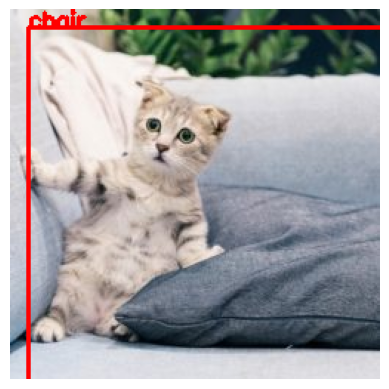

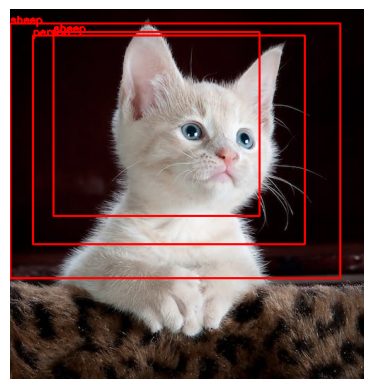

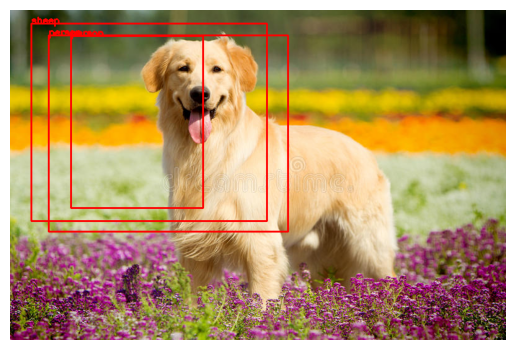

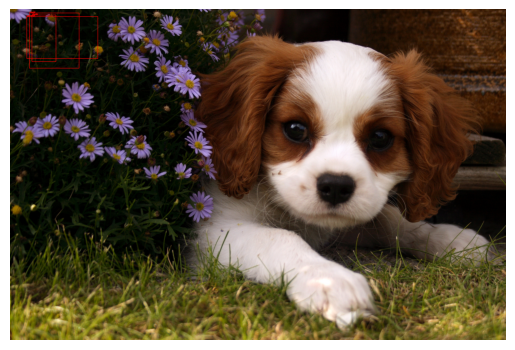

In [14]:
inverse_label_map = {v: k for k, v in label_map.items()}


def predict_image(image_path, model, transform, device, threshold=0.14):  # Add device argument here
    # Read and preprocess the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Send to device


    # Make predictions
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)

    # Visualize predictions
    image_with_boxes = image.copy()
    for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        if score > threshold:
            # Convert tensor box coordinates to integer values
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255,0,0), 2)
            # Use the inverse_label_map to get the class name from the predicted label
            cv2.putText(image_with_boxes, inverse_label_map[label.item()], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()


from google.colab import drive
device = torch.device('cuda')
model_path = '/content/drive/MyDrive/model_weights_with_resnet50.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()  # Ensure the model is in evaluation mode

# Usage:
image_path = 'cat_1.jpg'
predict_image(image_path, trainer.model, transform, device)  # Pass device here
image_path = 'cat_2.jpeg'
predict_image(image_path, trainer.model, transform, device)  # Pass device here
image_path = 'dog.jpg'
predict_image(image_path, trainer.model, transform, device)  # Pass device here
image_path = 'dog_6.jpg'
predict_image(image_path, trainer.model, transform, device)  # Pass device here


### Video

In [ ]:
def predict_video(video_path, model, transform, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            image_tensor = transform(frame).unsqueeze(0).to(trainer.device)

            model.eval()
            with torch.no_grad():
                prediction = model(image_tensor)

            for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
                if score > threshold:
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
                    cv2.putText(frame, str(label.item()), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

            out.write(frame)

        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage:
video_path = 'path_to_test_video.mp4'
predict_video(video_path, trainer.model, transform)
